In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

# Se lee el archivo Excel que contiene las tablas de datos en diferentes hojas.
# Read the new data
file_path = 'Data.xlsx'
new_data = pd.read_excel(file_path, sheet_name=None)

# Se combinan las tablas en un solo DataFrame utilizando 'customerID' como clave de unión.
# Merge the tables into a single DataFrame using 'customerID'
merged_data = pd.merge(new_data['Charges'], new_data['Other data'], on='customerID')
merged_data = pd.merge(merged_data, new_data['Churn'], on='customerID')


**EXPLORATORY ANALYSIS**

        customerID  MonthlyCharges  TotalCharges gender  SeniorCitizen  \
count         7043     7036.000000        7023.0   7043    7043.000000   
unique        7043             NaN        6513.0      2            NaN   
top     7590-VHVEG             NaN          20.2   Male            NaN   
freq             1             NaN          11.0   3555            NaN   
mean           NaN       64.737962           NaN    NaN       0.162147   
std            NaN       30.090674           NaN    NaN       0.368612   
min            NaN       18.250000           NaN    NaN       0.000000   
25%            NaN       35.487500           NaN    NaN       0.000000   
50%            NaN       70.325000           NaN    NaN       0.000000   
75%            NaN       89.850000           NaN    NaN       0.000000   
max            NaN      118.750000           NaN    NaN       1.000000   

       Partner Dependents       tenure PhoneService MultipleLines  ...  \
count     7043       7043  7043.00000

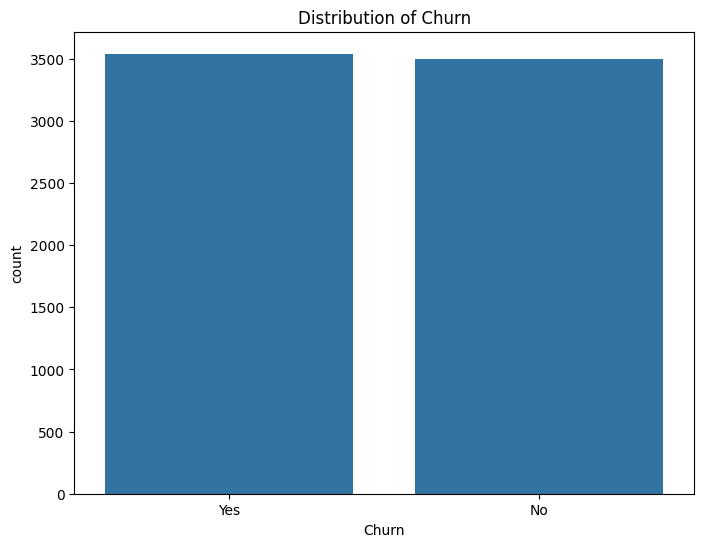

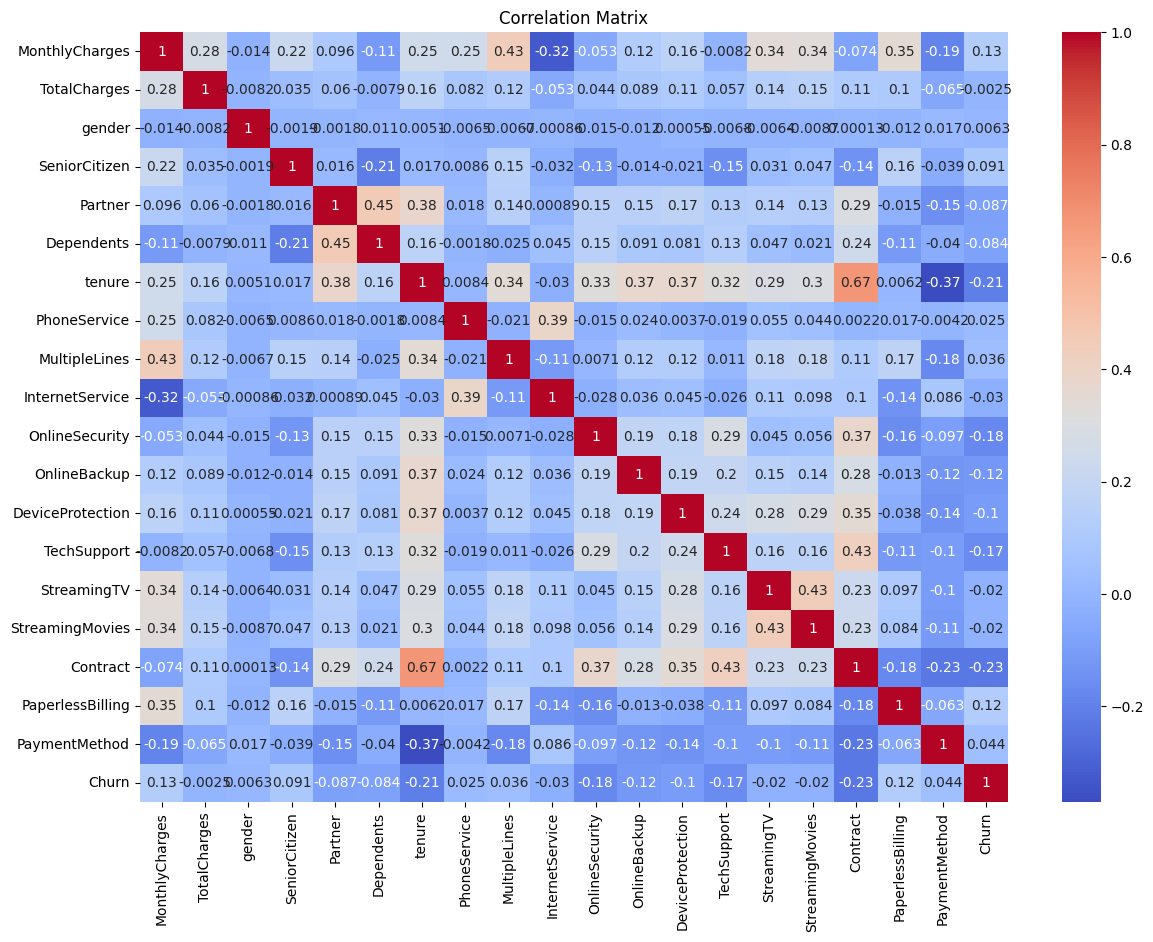

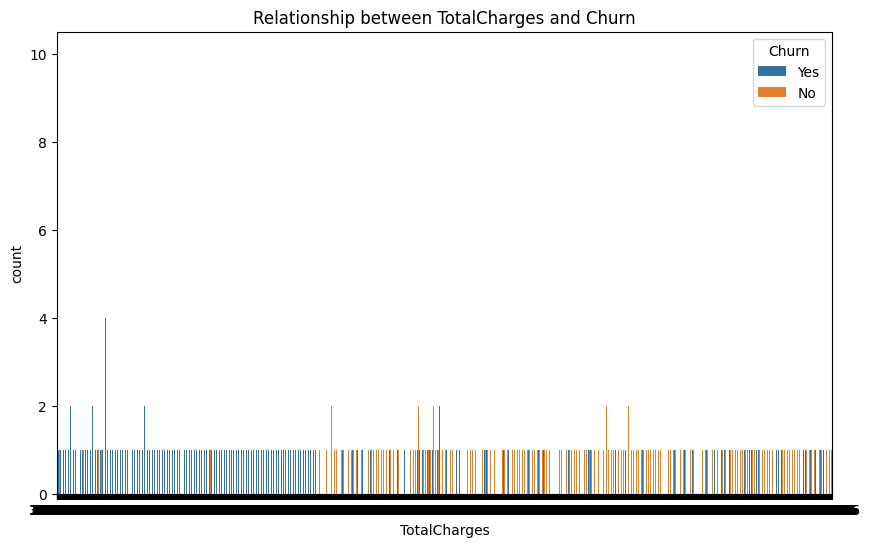

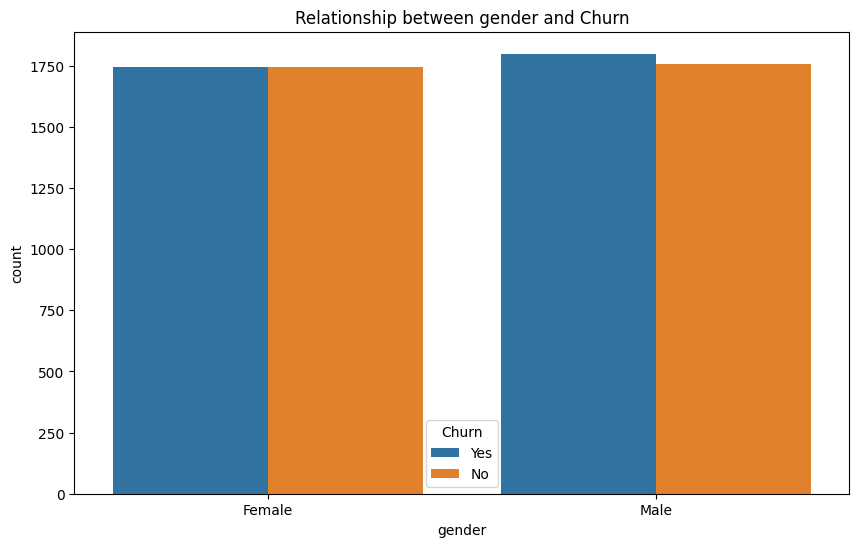

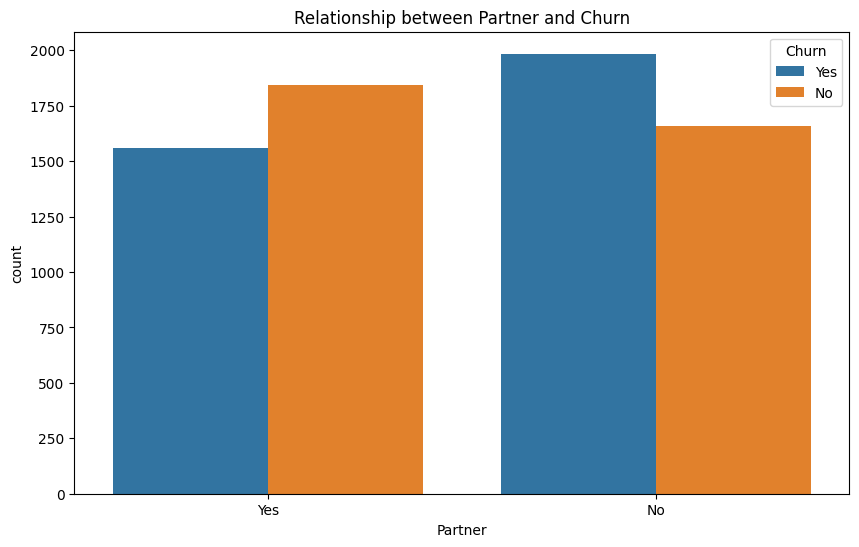

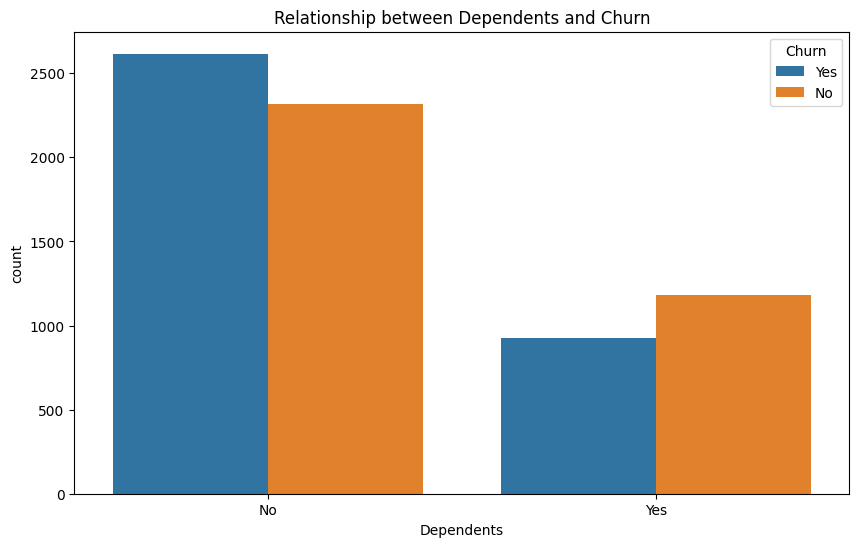

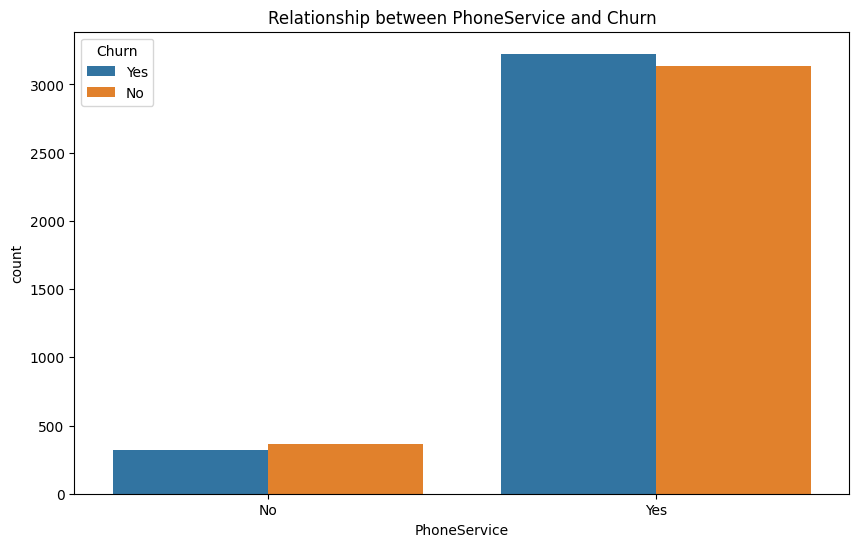

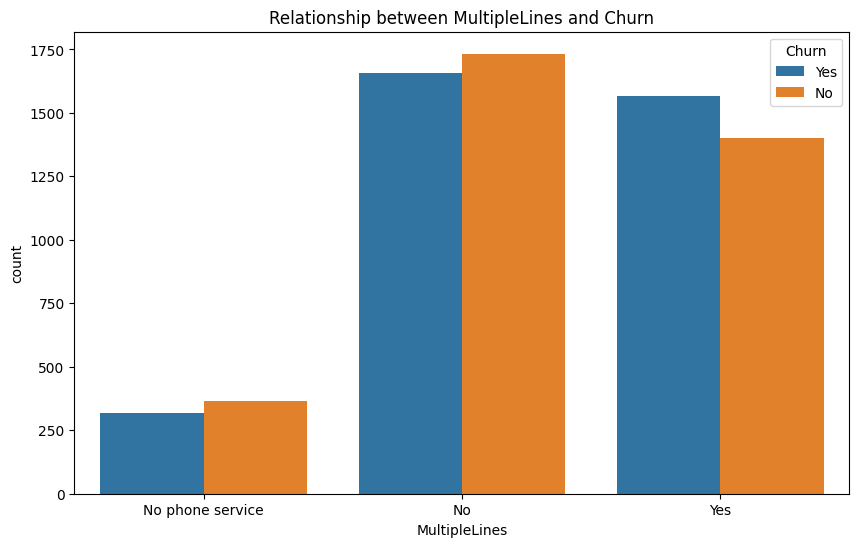

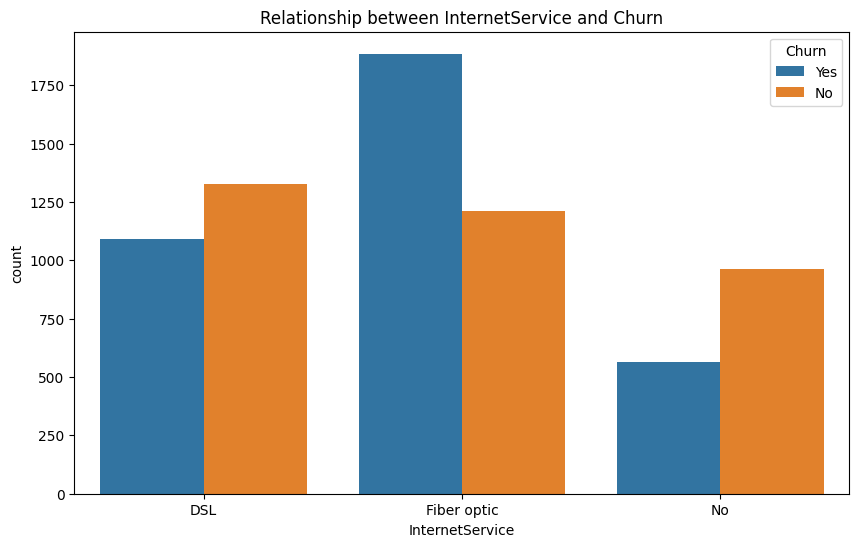

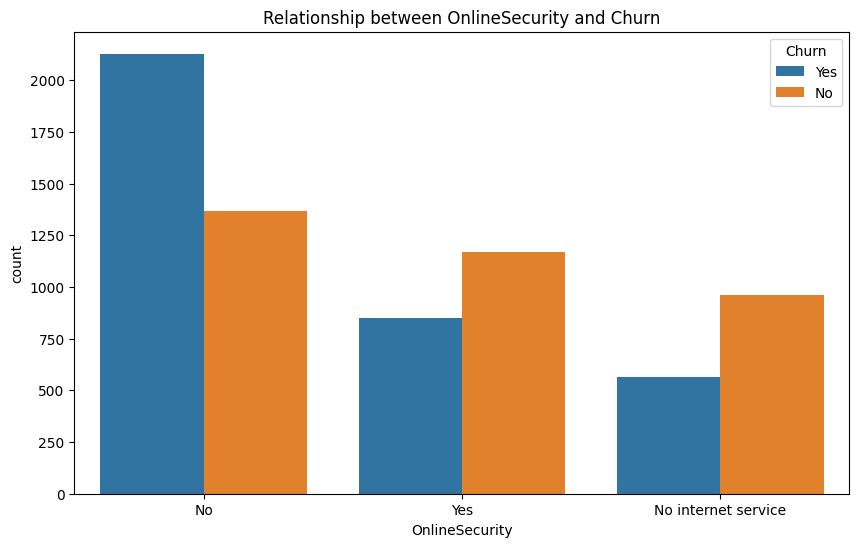

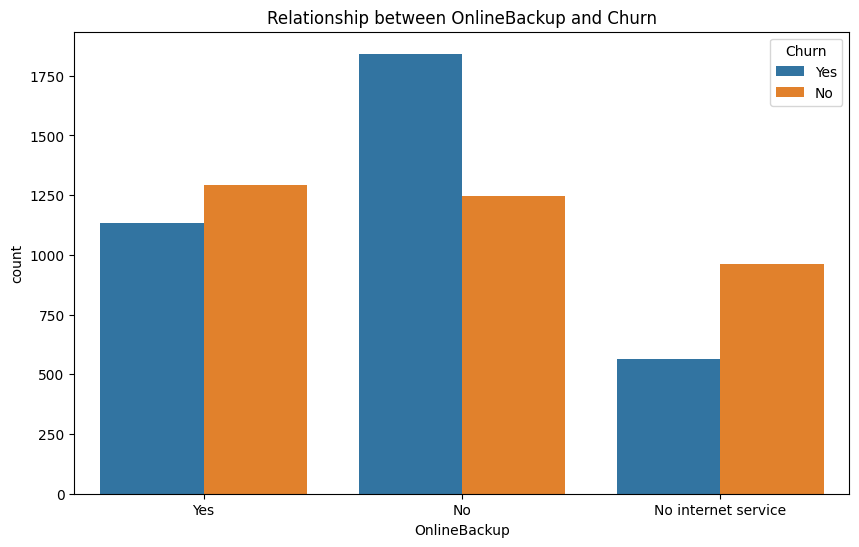

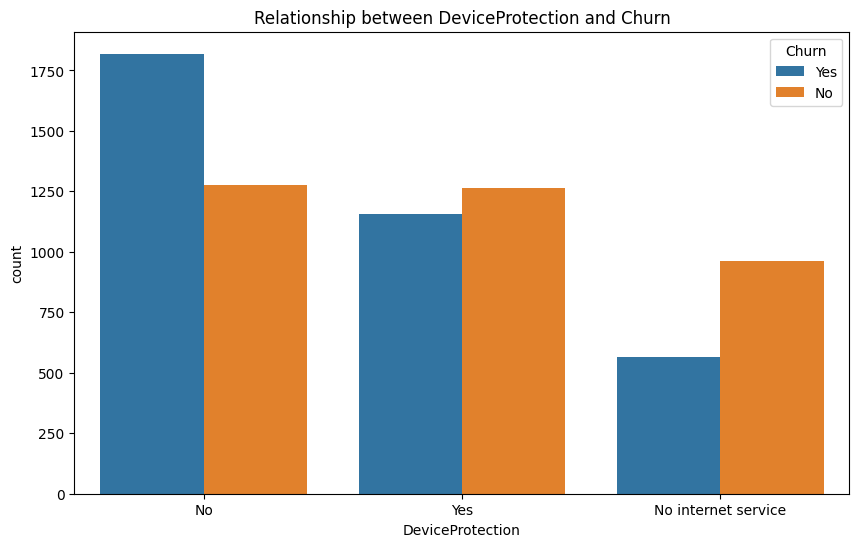

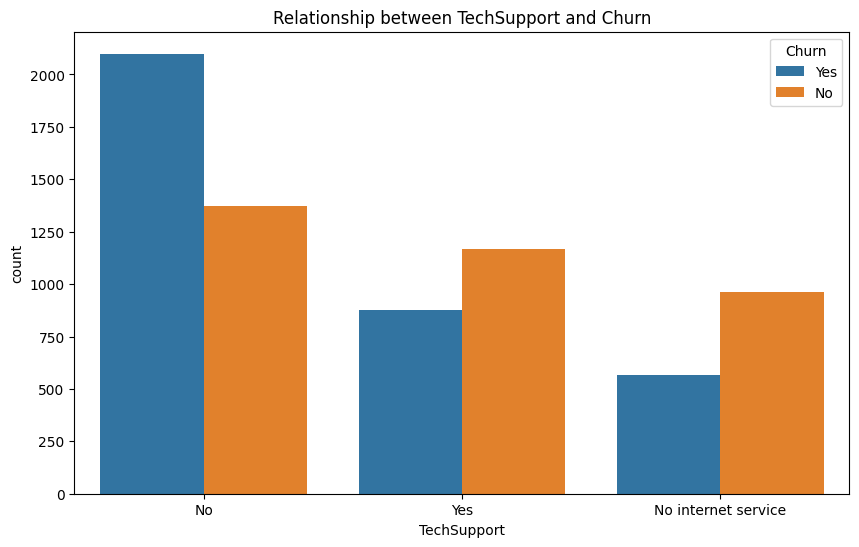

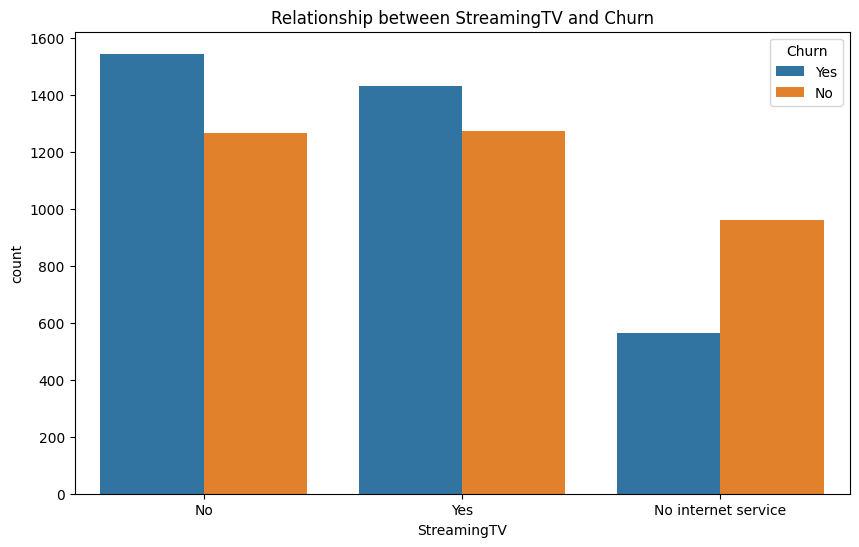

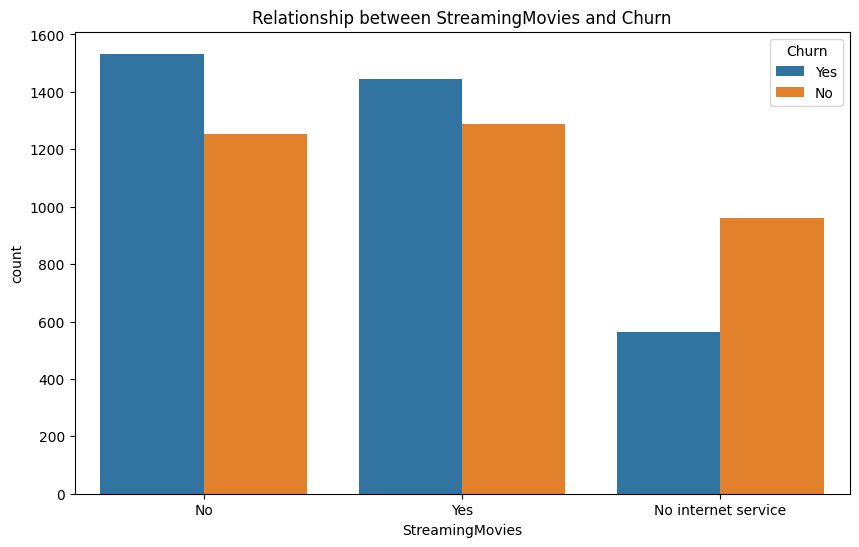

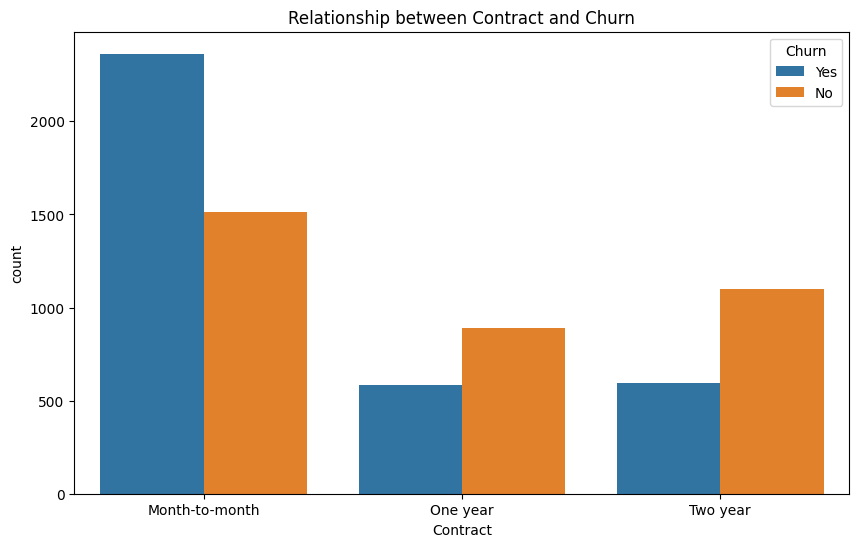

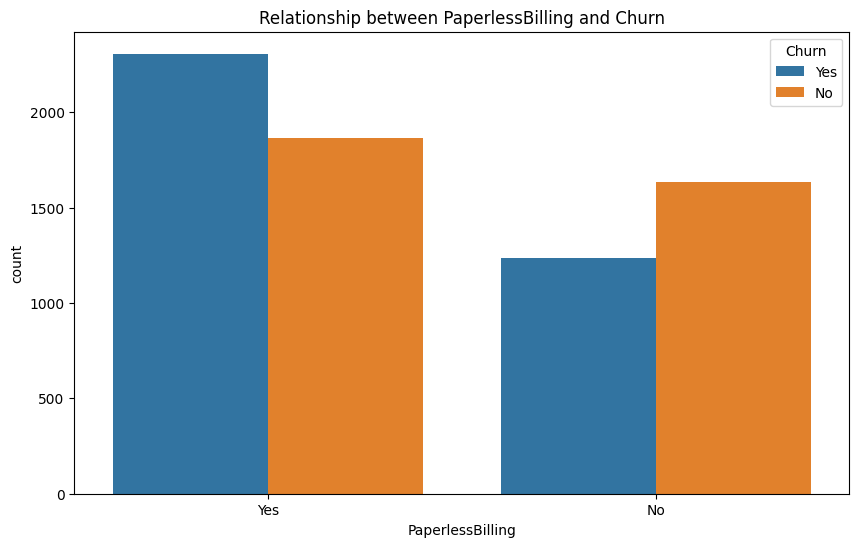

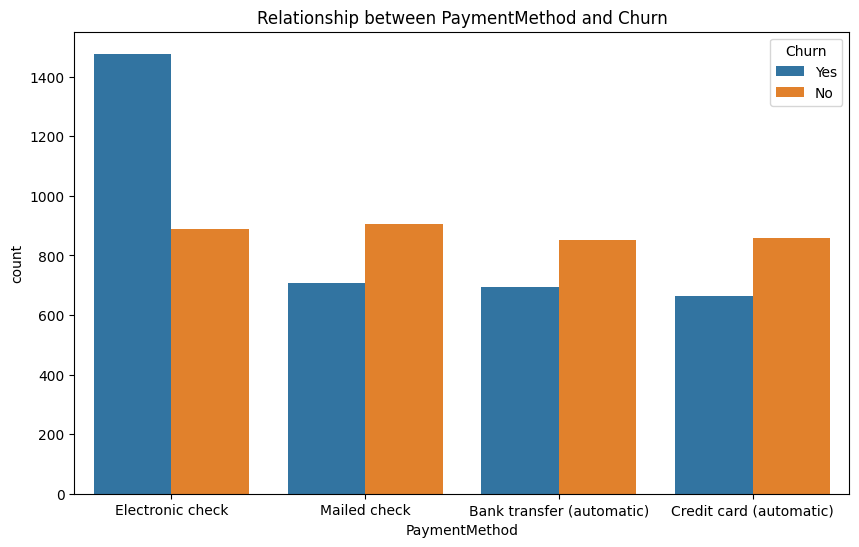

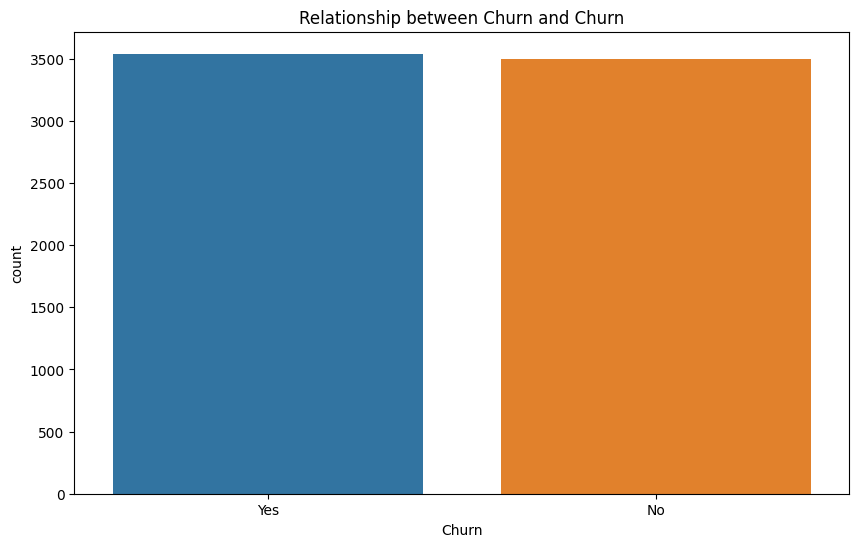

In [4]:
# Se genera un resumen estadístico de todas las columnas del DataFrame para entender la distribución y las características principales de los datos.
# Statistical Summary of the data frame to undestand the features and distributions
stat_summary = merged_data.describe(include='all')
print(stat_summary)

# Se visualiza la distribución de la variable objetivo 'Churn' para ver el balance de clases (churn vs no churn).
# Distribution of the target variable 'Churn'
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=merged_data)
plt.title('Distribution of Churn')
plt.show()

# Se crea un nuevo DataFrame excluyendo 'customerID' para realizar el análisis de correlación.
# Create a new DataFrame for correlation analysis excluding 'customerID'
corr_data = merged_data.drop(columns=['customerID'])

# Se convierten todas las columnas categóricas a tipo string para facilitar la codificación uniforme.
# Convert all categorical columns to string type for uniform encoding
for column in corr_data.select_dtypes(include=['object']).columns:
    corr_data[column] = corr_data[column].astype(str)

# Se codifican las variables categóricas usando LabelEncoder para convertirlas en valores numéricos, necesarios para el análisis de correlación.
# Encoding Categorical Variables for correlation analysis
label_encoders = {}
for column in corr_data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    corr_data[column] = label_encoders[column].fit_transform(corr_data[column])

# Se calcula y visualiza la matriz de correlación para identificar relaciones entre las variables.
# Correlation Matrix
plt.figure(figsize=(14, 10))
corr_matrix = corr_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Se visualiza la relación entre las variables categóricas y 'Churn' para identificar posibles patrones.
# Relationship between features and 'Churn'
for column in merged_data.select_dtypes(include=['object']).columns:
    if column != 'customerID':
        plt.figure(figsize=(10, 6))
        sns.countplot(x=column, hue='Churn', data=merged_data)
        plt.title(f'Relationship between {column} and Churn')
        plt.show()



**TREATING PATHOLOGIES IN THE DATA**

In [5]:
# Se limpia la columna 'TotalCharges' para eliminar espacios en blanco y se convierte a formato numérico.
# Clean 'TotalCharges' column and convert to numeric
merged_data['TotalCharges'] = merged_data['TotalCharges'].astype(str).str.strip().replace('', '0')
merged_data['TotalCharges'] = pd.to_numeric(merged_data['TotalCharges'], errors='coerce')

# Se realiza el mismo proceso para 'MonthlyCharges' y 'tenure'.
# Convert other columns to numeric and handle errors
for column in ['MonthlyCharges', 'tenure']:
    merged_data[column] = merged_data[column].astype(str).str.strip().replace('', '0')
    merged_data[column] = pd.to_numeric(merged_data[column], errors='coerce')

# Se rellenan los valores faltantes en las columnas numéricas con la media de la columna.
# Handling Missing Values
# Fill missing values in numerical columns with the mean
for column in merged_data.select_dtypes(include=['float64', 'int64']).columns:
    merged_data[column].fillna(merged_data[column].mean(), inplace=True)

# Se codifican las variables categóricas nuevamente usando LabelEncoder para convertirlas en valores numéricos.
# Encoding Categorical Variables using LabelEncoder to numerical values
label_encoders = {}
for column in merged_data.select_dtypes(include=['object']).columns:
    if column != 'customerID':
        label_encoders[column] = LabelEncoder()
        merged_data[column] = label_encoders[column].fit_transform(merged_data[column])

# Se normalizan las variables numéricas para tener media 0 y desviación estándar 1, lo que mejora el rendimiento de muchos algoritmos de machine learning.
# Normalizing Numerical Variables with mean 0 en stdv 1
scaler = StandardScaler()
numerical_columns = ['MonthlyCharges', 'TotalCharges', 'tenure']
merged_data[numerical_columns] = scaler.fit_transform(merged_data[numerical_columns])

# Se crean nuevas características derivadas:
# 'Charges_per_Tenure' mide el costo total dividido por el tiempo (tenure), lo que da una idea del costo por mes.
# 'Monthly_Tenure_Ratio' mide el costo mensual dividido por el tiempo (tenure), lo que puede indicar la consistencia del gasto a lo largo del tiempo.
### Feature Engineering
# 'Charges_per_Tenure' measures the total cost divided by the tenure, providing an idea of the cost per month.
# 'Monthly_Tenure_Ratio' measures the monthly cost divided by the tenure, which can indicate the consistency of spending over time.
merged_data['Charges_per_Tenure'] = merged_data['TotalCharges'] / (merged_data['tenure'] + 1)
merged_data['Monthly_Tenure_Ratio'] = merged_data['MonthlyCharges'] / (merged_data['tenure'] + 1)



**PROPOSING MODELS**

In [6]:
# Se separan las características (X) de la variable objetivo (y)
# Separate features and target variable
X = merged_data.drop(columns=['customerID', 'Churn'])
y = merged_data['Churn']

# Se divide el conjunto de datos en conjuntos de entrenamiento y prueba para evaluar el rendimiento del modelo
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Se definen los modelos que se van a entrenar y evaluar
# Define the models tha will be trained and evaluated
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Se entrenan los modelos y se evalúan usando diferentes métricas:MSE (Proba),'R² (Proba), MSE (Class), R² (Class), Accuracy, Precision, Recall, F1 Score y ROC AUC.
# Train and evaluate the models with MSE (Proba),'R² (Proba), MSE (Class), R² (Class), Accuracy, Precision, Recall, F1 Score y ROC AUC.
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)

    # Predict probabilities for R^2 calculation (for classification models)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test)

    # Predict classes
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse_proba = mean_squared_error(y_test, y_pred_proba)
    r2_proba = r2_score(y_test, y_pred_proba)
    mse_class = mean_squared_error(y_test, y_pred)
    r2_class = r2_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results[model_name] = {
        'MSE (Proba)': mse_proba,
        'R² (Proba)': r2_proba,
        'MSE (Class)': mse_class,
        'R² (Class)': r2_class,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

# Display the results
results_df = pd.DataFrame(results).T
print(results_df)



                     MSE (Proba)  R² (Proba)  MSE (Class)  R² (Class)  \
Logistic Regression     0.222024    0.110915     0.355571   -0.423870   
Gradient Boosting       0.221514    0.112959     0.359830   -0.440922   
Decision Tree           0.454479   -0.819942     0.454223   -0.818915   
Random Forest           0.239957    0.039102     0.394606   -0.580183   

                     Accuracy  Precision    Recall  F1 Score   ROC AUC  
Logistic Regression  0.644429   0.673282  0.605769  0.637744  0.689632  
Gradient Boosting    0.640170   0.677939  0.578297  0.624166  0.683763  
Decision Tree        0.545777   0.562857  0.541209  0.551821  0.544657  
Random Forest        0.605394   0.638264  0.545330  0.588148  0.644170  


**MODEL TUNNING**

In [ ]:
# Define the model and hyperparameter grid for Logistic Regression
# Logistic Regression model with a maximum of 1000 iterations
logistic_model = LogisticRegression(max_iter=1000)

# Hyperparameter grid for Logistic Regression
logistic_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization techniques
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # Algorithms for optimization
}

# Create the GridSearchCV object for Logistic Regression
# GridSearchCV to find the best hyperparameters based on accuracy
logistic_grid_search = GridSearchCV(logistic_model, logistic_param_grid, cv=5, scoring='accuracy')
logistic_grid_search.fit(X_train, y_train)

# Best hyperparameters and best score for Logistic Regression
print("Best parameters for Logistic Regression:", logistic_grid_search.best_params_)
print("Best score for Logistic Regression:", logistic_grid_search.best_score_)

# Define the model and hyperparameter grid for Gradient Boosting
# Gradient Boosting model with a random state for reproducibility
gb_model = GradientBoostingClassifier(random_state=42)

# Hyperparameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

# Create the GridSearchCV object for Gradient Boosting
# GridSearchCV to find the best hyperparameters based on accuracy
gb_grid_search = GridSearchCV(gb_model, gb_param_grid, cv=5, scoring='accuracy')
gb_grid_search.fit(X_train, y_train)

# Best hyperparameters and best score for Gradient Boosting
print("Best parameters for Gradient Boosting:", gb_grid_search.best_params_)
print("Best score for Gradient Boosting:", gb_grid_search.best_score_)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour

Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score for Logistic Regression: 0.6338313099585344


                      Logistic Regression  Gradient Boosting
MonthlyCharges                   0.464416           0.129594
TotalCharges                    -0.351348           0.122202
gender                           0.019420           0.005671
SeniorCitizen                    0.206743           0.007164
Partner                         -0.045593           0.005996
Dependents                       0.026555           0.004676
tenure                          -0.163382           0.109361
PhoneService                    -0.185488           0.001272
MultipleLines                    0.102312           0.014208
InternetService                  0.133202           0.008594
OnlineSecurity                  -0.130629           0.068236
OnlineBackup                    -0.070816           0.008230
DeviceProtection                -0.028969           0.001751
TechSupport                     -0.113808           0.024042
StreamingTV                      0.018980           0.007632
StreamingMovies         

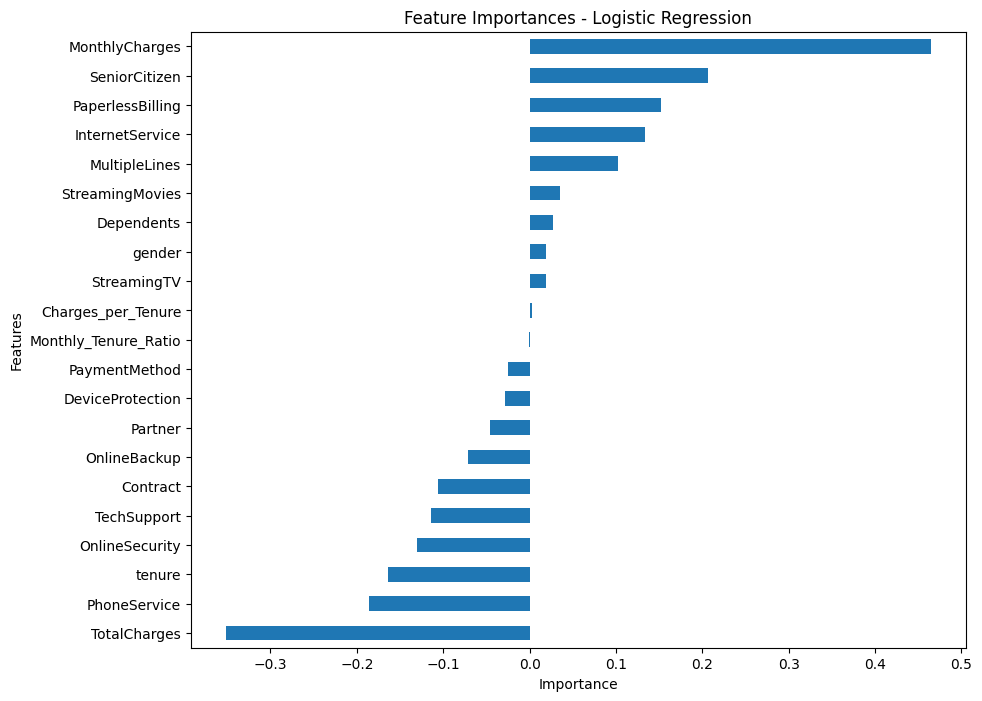

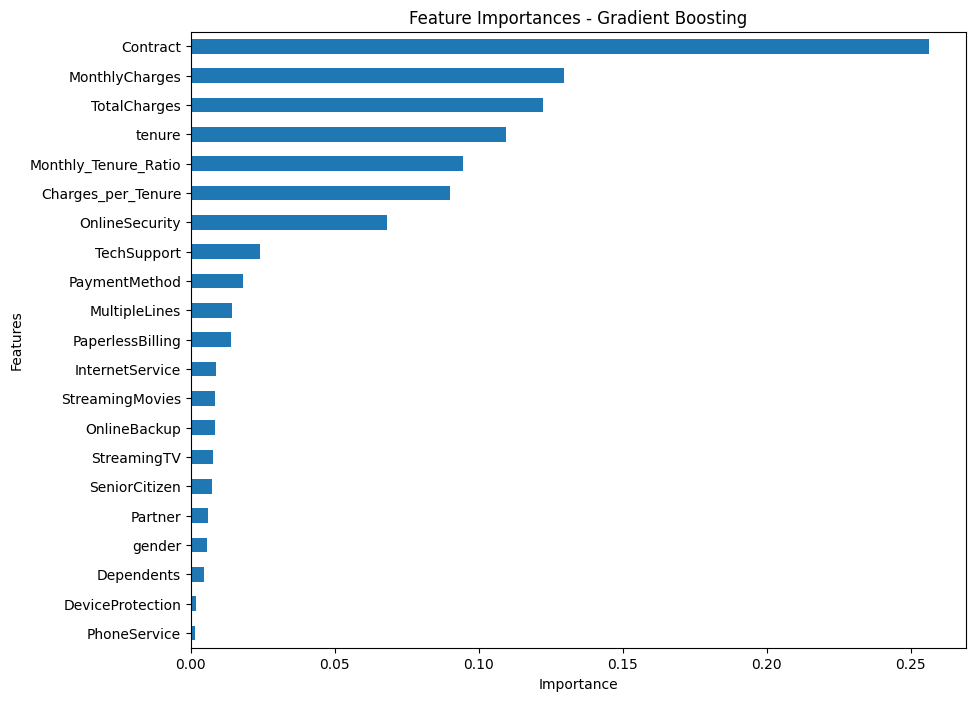

In [7]:
# Definir los modelos con los mejores hiperparámetros
# Define models with the best hyperparamethers
models = {
    'Logistic Regression': LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', max_iter=1000),
    'Gradient Boosting': GradientBoostingClassifier(
        learning_rate=0.01,
        max_depth=5,
        min_samples_leaf=2,
        min_samples_split=10,
        n_estimators=200,
        subsample=0.9,
        random_state=42
    )
}


# Obtener las importancias de características de los modelos seleccionados y calcular métricas
# Best features and metrics
feature_importances = {}
results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    if hasattr(model, 'coef_'):
        importance = model.coef_[0]
    elif hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        importance = np.zeros(X_train.shape[1])

    feature_importances[model_name] = importance

    # Realizar predicciones
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calcular métricas de evaluación
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    mse_proba = mean_squared_error(y_test, y_pred_proba)
    r2_proba = r2_score(y_test, y_pred_proba)
    mse_class = mean_squared_error(y_test, y_pred)
    r2_class = r2_score(y_test, y_pred)

    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'MSE (Proba)': mse_proba,
        'R² (Proba)': r2_proba,
        'MSE (Class)': mse_class,
        'R² (Class)': r2_class
    }

# Crear un DataFrame para mostrar las importancias de características
# Dataframe for important features
feature_importances_df = pd.DataFrame(feature_importances, index=X.columns)
print(feature_importances_df)

# Crear un DataFrame para mostrar las métricas de evaluación
# Dataframe for evaluation metrics
results_df = pd.DataFrame(results).T
print(results_df)

# Graficar las características más importantes para Regresión Logística
# Graph for bes features logistic regression
plt.figure(figsize=(10, 8))
feature_importances_df['Logistic Regression'].sort_values().plot(kind='barh')
plt.title('Feature Importances - Logistic Regression')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Graficar las características más importantes para Gradient Boosting
# Graph for best features gradient boosting
plt.figure(figsize=(10, 8))
feature_importances_df['Gradient Boosting'].sort_values().plot(kind='barh')
plt.title('Feature Importances - Gradient Boosting')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()






